In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [2]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

random.shuffle(letters2)

for k, v in zip(letters1, letters2):
    true_mapping[k] = v

In [3]:
M = np.ones((26, 26))

pi = np.zeros(26)

def update_transition(ch1, ch2):
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i, j] += 1
    
def update_pi(ch):
    i = ord(ch) - 97
    pi[i] += 1
    
def get_word_prob(word):
    i = ord(word[0]) - 97
    logp = np.log(pi[i])
    for ch in word[1:]:
        j = ord(ch) - 97
        logp += np.log(M[i, j])
        i = j
        
    return logp

def get_sequence_prob(words):
    if type(words) == str:
        words = words.split()
        
    logp = 0
    for word in words:
        logp += get_word_prob(word)
        
    return logp

In [4]:
if not os.path.exists('data.txt'):
    print("Downloading data.....")
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt') 
    with open('data.txt', 'w') as f:
        f.write(r.content.decode())

In [5]:
regex = re.compile('[^a-zA-Z]')
for line in open('data.txt'):
    line = line.rstrip()
    if line:
        line = regex.sub(' ', line)
        
    tokens = line.lower().split()
    for token in tokens:
        ch0 = token[0]
        update_pi(ch0)
        
        for ch1 in token[1:]:
            #update_pi(ch1)
            update_transition(ch0, ch1)
            ch0 = ch1
            
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [6]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

In [7]:
def encode_message(msg):
    msg = msg.lower()
    msg = regex.sub(' ', msg)
    coded_msg = []
    for ch in msg:
        coded_ch = ch
        if ch in true_mapping:
            coded_ch = true_mapping[ch]
            
        coded_msg.append(coded_ch)
        
    return ''.join(coded_msg)

encoded_message = encode_message(original_message)

In [8]:
def decode_msg(msg, word_map):
    decoded_msg = []
    for ch in msg:
        decode_ch = ch
        if ch in word_map:
            decode_ch = word_map[ch]
            
        decoded_msg.append(decode_ch)
        
    return ''.join(decoded_msg)

In [9]:
dna_pool = []
for _ in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [10]:
def evolve_offspring(dna_pool, n_childen):
    offspring = []
    for dna in dna_pool:
        for _ in range(n_childen):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))
            tmp = copy[j]
            copy[j] = copy[k]
            copy[k] = tmp
            offspring.append(copy)
            
    return offspring + dna_pool

In [11]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
    if i > 0:
        dna_pool = evolve_offspring(dna_pool, 3)
        
    dna2score = {}
    for dna in dna_pool:
        current_map = {}
        for k, v in zip(letters1, dna):
            current_map[k] = v
            
        decoded_msg = decode_msg(encoded_message, current_map)
        score = get_sequence_prob(decoded_msg)
        dna2score[''.join(dna)] = score
        if score > best_score:
            best_score = score
            best_dna = dna
            best_map = current_map
            
    scores[i] = np.mean(list(dna2score.values()))
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
    dna_pool = [list(k) for k, v in sorted_dna[:5]]
    
    if i%200 == 0:
        print("iter :", i, " score:", scores[i], " best so far:", best_score)

iter : 0  score: -2022.5102839045728  best so far: -1806.8323115567655
iter : 200  score: -1018.7092267883351  best so far: -934.3762341787831
iter : 400  score: -1027.0332417142704  best so far: -929.5902922650557
iter : 600  score: -1024.6259564548902  best so far: -929.5902922650557
iter : 800  score: -1030.3436908508115  best so far: -929.5902922650557


In [12]:
decoded_msg = decode_msg(encoded_message, best_map)

print('LL of decoded message: ', get_sequence_prob(decoded_msg))
print('LL of true message: ', get_sequence_prob(regex.sub(' ', original_message.lower())))

for true, v in true_mapping.items():
    pred = best_map[v]
    if true != pred:
        print("true: %s, pred: %s" %(true, pred))

LL of decoded message:  -929.5902922650557
LL of true message:  -933.0312453751817
true: j, pred: z
true: k, pred: j
true: z, pred: k


In [13]:
print(original_message)
print(decoded_msg)

I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.

i then lounged down the street and found  as i expected  that there was a mews in a lane which runs down by one wall of the garden  i lent the ostlers a hand in rubbing down their horses  and received in exchange twopence  a glass of half and half  two fills of shag tobacco  and as much information as i could desire about miss adler  to say nothing of half a doken other people in the neighbourhood in whom i was not in the least interested  but whose biographies i was compelled to listen to  


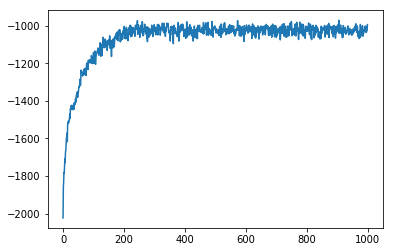

In [14]:
plt.plot(scores)
plt.show()